In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"
dir_TNGcube = dir_repo+"/TNGcube"

sys.path.append(dir_KLens)
from KLtool import *

sys.path.append(dir_TNGcube)
from TNGcube import *

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import lambda_to_velocity, velocity_to_lambda

Populating the interactive namespace from numpy and matplotlib


In [2]:
subhalo = pickle.load(open('../notebooks/subhalo_35.pkl', 'rb'))

In [3]:
pars = {}
pars['spinR'] = [0, 0, -1]
pars['sini'] = 1.
pars['theta_int'] = 0. #np.pi/6.
pars['g1'] = 0.
pars['g2'] = 0.
pars['redshift'] = 0.3
pars['psfFWHM'] = 0.5
pars['sigma_thermal'] = 16.  # [unit: km/s]


pars['slitAngles'] = [0., np.pi/2]

lambda_cen0 = ParametersTNG.lineLambda0['Halpha']
#lambda_cen0 = (lineLambda0['OIIa']+lineLambda0['OIIb'])/2.

pars['lambda_cen'] = (1+pars['redshift'])*lambda_cen0

In [4]:
pars['expTime'] = 30.*60.              # [unit: sec]
pars['area'] = 3.14 * (1000./2.)**2    # telescope area [unit: cm2]

pars['ref_SDSS_lineL'] = 3.*1e-17      # [unit: erg/s/Angstrom/cm2]    # * u.erg/u.second/u.Angstrom/u.cm**2

fiber_SDSS = np.pi * 1.5**2.           # fiber size [unit: arcsec2]
refSDSSspec = pars['ref_SDSS_lineL'] * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print('reference SDSS fiber spec:', refSDSSspec)

pars['lineflux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]
pars['lineflux']

reference SDSS fiber spec: 2.9999999999999994e-16 erg / (cm2 nm s)


4.244131815783875e-17

In [5]:
par_meta = {}
# optimal par_meta for subhaloID=46, snap=75
#par_meta['theta'] = 15. *np.pi/180.
#par_meta['dx'] = [0.8,1.3,0]
#par_meta['dv'] = [0.0,0.,4.5]

par_meta['theta'] = 0. *np.pi/180.
par_meta['dx'] = [0.,0.,0.]
par_meta['dv'] = [0.0,0.,0.]

In [6]:
mock = TNGmock(pars=pars, subhalo=subhalo, par_meta=par_meta)

### default auto mock generation

In [7]:
dataInfo = mock.gen_mock_data(noise_mode=0)

/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/TNGcube.py:672: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8110344310>)

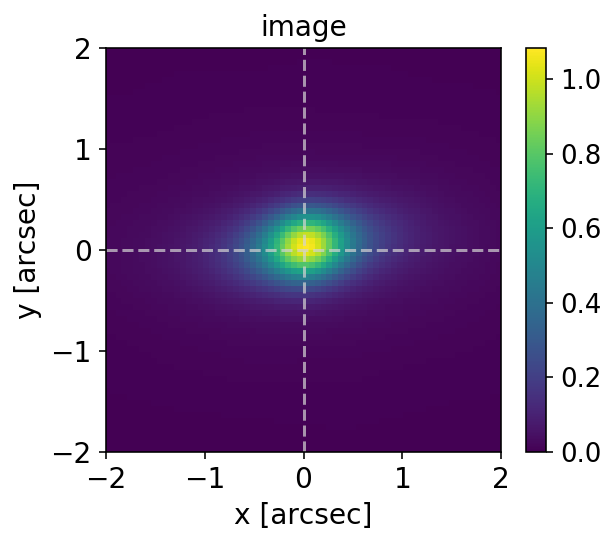

In [8]:
dataInfo['image'].display(xlim=[-2., 2.])

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


time cost in gaussFit_spec2D: 0.4729421138763428 (secs)


/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8110519b90>)

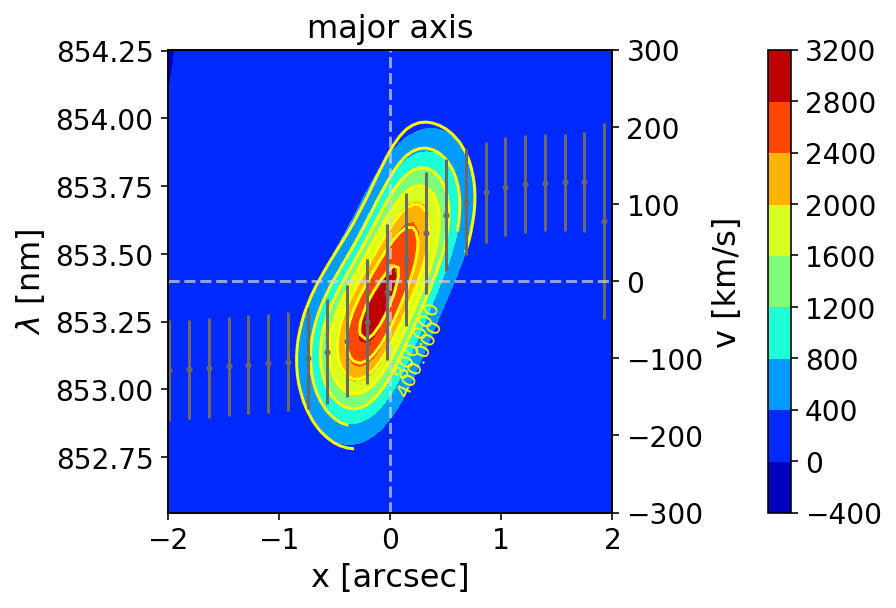

In [9]:
model_major = dataInfo['spec'][0].GF.model
dataInfo['spec'][0].display(xlim=[-2., 2], vlim=[-300, 300], mark_fit=True, model=model_major, title='major axis')

time cost in gaussFit_spec2D: 0.47324228286743164 (secs)


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f814117b3d0>)

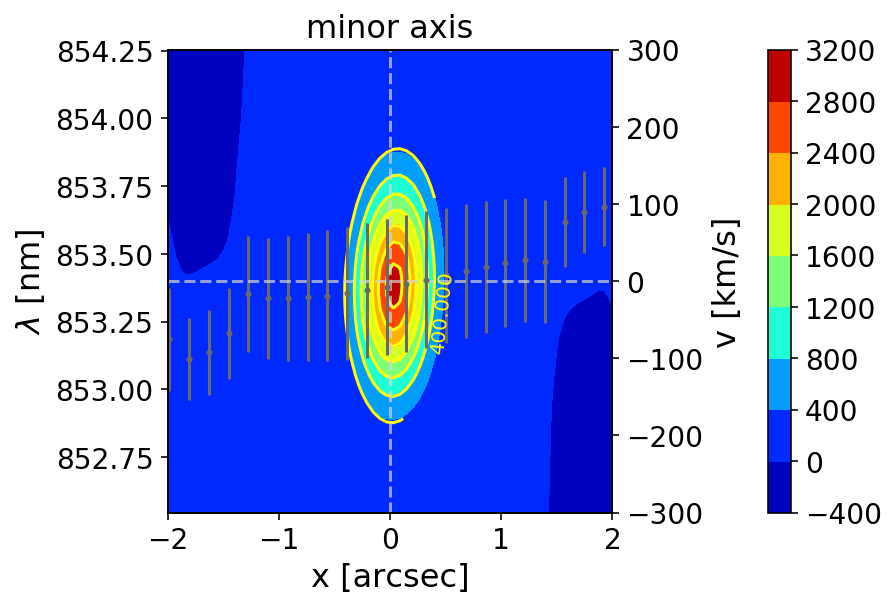

In [10]:
model_minor = dataInfo['spec'][1].GF.model
dataInfo['spec'][1].display(xlim=[-2., 2], vlim=[-300, 300], mark_fit=True, model=model_minor, title='minor axis')

time cost in gaussFit_spec2D: 0.0565800666809082 (secs)
time cost in gaussFit_spec2D: 0.08166193962097168 (secs)


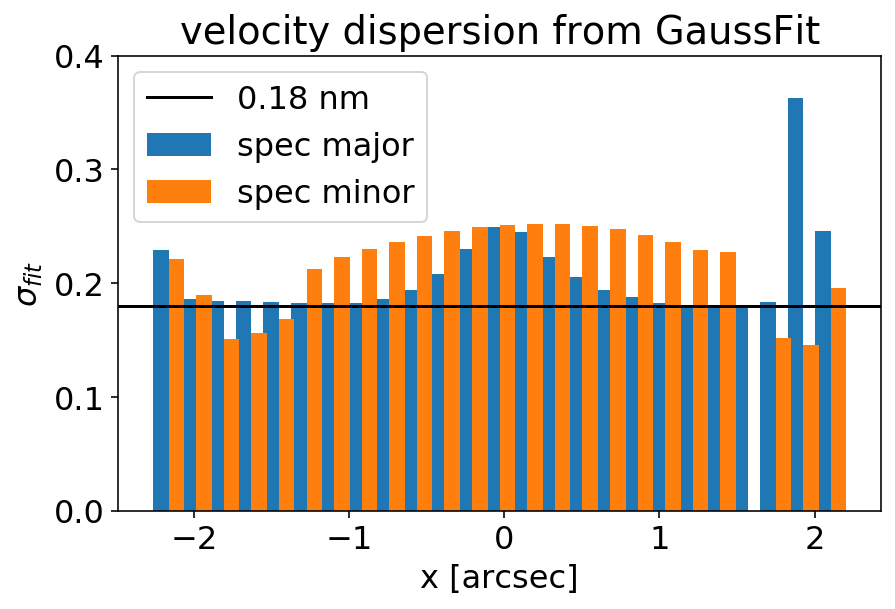

In [11]:
spec2D_0 = dataInfo['spec'][0].cutout(xlim=[-2.2, 2.2])
spec2D_1 = dataInfo['spec'][1].cutout(xlim=[-2.2, 2.2])
cenL0, amp0, sigma0 = spec2D_0.GF.fit_spec2D()
cenL1, amp1, sigma1 = spec2D_1.GF.fit_spec2D()

dj=3
x = spec2D_1.spaceGrid[::dj]
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(6.5, 4.5))
bar0 = ax.bar(x - width/2, sigma0[::dj], width, label='spec major')
bar1 = ax.bar(x + width/2, sigma1[::dj], width, label='spec minor')

ax.axhline(y=0.18, color='k', label='0.18 nm')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\sigma_{fit}$')
ax.set_title('velocity dispersion from GaussFit')

ax.set_xlabel('x [arcsec]')

ax.set_ylim([0., 0.4])
ax.legend()

fig.tight_layout()

plt.show()

In [12]:
#plot_image( data_info['image'].array, spaceGrid=data_info['spaceGrid'], xlim=[-2.8, 2.8])

#spec_arrays = [data_info['spec'][0].array, data_info['spec'][1].array]
#plot_specs(spec_arrays, slitAngles=mock.Pars.fid['slitAngles'], spaceGrid=data_info['spaceGrid'], lambdaGrid=data_info['lambdaGrid'], xlim=[-2.8, 2.8])

## ------ For detailed debug: methods of TNGmock ------

In [13]:
mock = TNGmock(pars=pars, subhalo=subhalo, par_meta=par_meta)

# 1. compute total rotation matrix, Rtot
R_spin = spin_rotation(spin0=mock.subhalo.info['spin'], spinR=[0, 0, -1])
R_sini = sini_rotation(sini=mock.Pars.fid['sini'])
R_pa = PA_rotation(theta=mock.Pars.fid['theta_int'])

Rtot = R_pa@R_sini@R_spin

# 2.0 Perform rotation to subhalo
mock.subhalo.rotation(Rtot)

In [14]:
# 2.1 Perform additional adjustment to subhalo (if par_meta is set)
Rth = PA_rotation(theta=mock.par_meta['theta'])
mock.subhalo.rotation(Rth)
mock.subhalo.recenter_pos(dx=mock.par_meta['dx'])
mock.subhalo.recenter_vel(dv=mock.par_meta['dv'])

In [15]:
# 2.2 add Shear to subhalo
mock.subhalo.shear(g1=mock.Pars.fid['g1'], g2=mock.Pars.fid['g2'])

In [16]:
# 3. generate specCube
#massCube = mock.gen_massCube(ptlTypes=['gas', 'stars'], lineTypes=mock.line_species, weights='mass')
#massCube = mock.gen_massCube(ptlTypes=['gas'], lineTypes=mock.line_species, weights='mass')
massCube = mock.gen_massCube(ptlTypes=['gas'], lineTypes=mock.line_species, weights='SFR')
mock.specCube = mock.mass_to_light(massCube)

# 3.1 add psf for each plan at lambdaGrid[i]
#mock.specCube.add_psf(psfFWHM=mock.Pars.fid['psfFWHM'], psf_g1=mock.Pars.fid['psf_g1'], psf_g2=mock.Pars.fid['psf_g2'])

# 3.2 smooth spectrum
    # thermal part
mock.sigma_thermal_nm = mock.cal_sigma_thermal_nm(sigma_thermal_kms=mock.Pars.fid['sigma_thermal'])
    # spectral resoultion part
mock.sigma_resolution_nm = mock.Pars.fid['lambda_cen']/mock.Pars.fid['Resolution']
mock.sigma_tot = np.sqrt(mock.sigma_thermal_nm**2 +  mock.sigma_resolution_nm**2)
mock.specCube.add_spec_sigma_approx(sigma=mock.sigma_tot)
#mock.specCube.add_spec_sigma(resolution=mock.Pars.fid['Resolution'], sigma_thermal_nm=mock.sigma_thermal_nm)

# 3.3 flux renormalization
mock.specCube = mock.flux_renorm(mock.specCube)

In [17]:
spectra = Slit(mock.specCube, slitWidth=mock.Pars.fid['slitWidth']).get_spectra(slitAngles=mock.Pars.fid['slitAngles'])

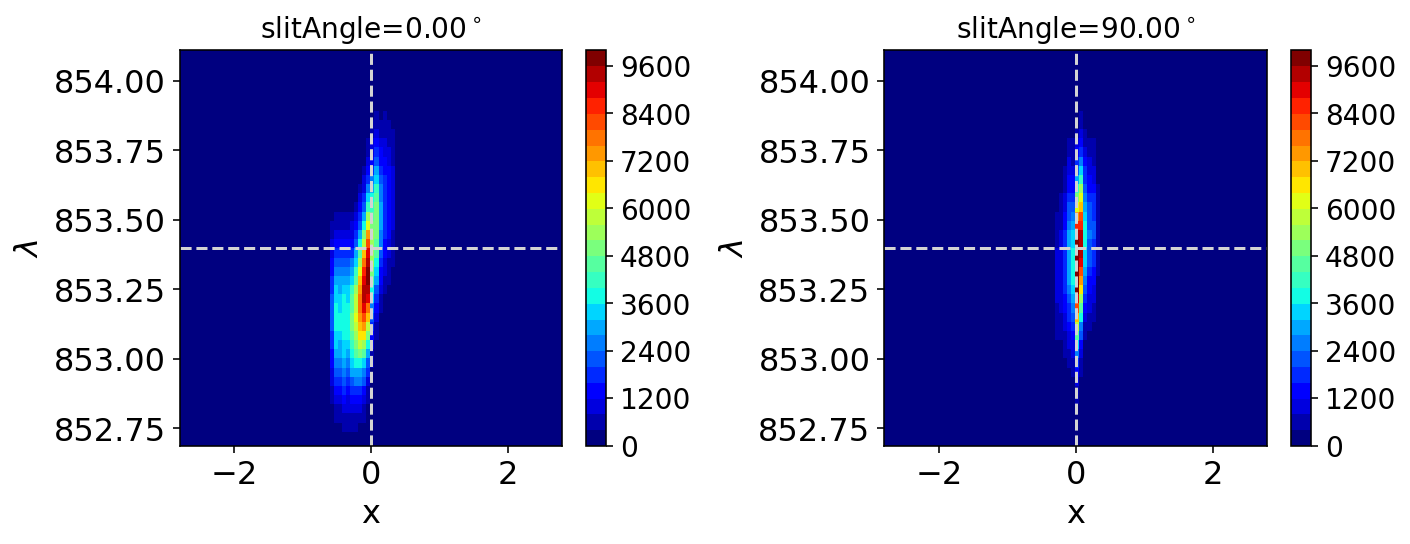

sigma_thermal: 0.046 [nm]       (16.00 km/s)
sigma_resolution: 0.171 [nm]    (59.96 km/s)
sigma_tot: 0.177 [nm]           (62.06 km/s)


In [18]:
vlim = [-250, 250]
ylim = velocity_to_lambda(vlim, mock.lambda0, mock.z)
plot_specs(spectra, slitAngles=mock.Pars.fid['slitAngles'], 
           spaceGrid=mock.Pars.spaceGrid, lambdaGrid=mock.Pars.lambdaGrid, xlim=[-2.8, 2.8], ylim=ylim)


# print information
sigma_thermal_kms = mock.Pars.fid['sigma_thermal']
print(f'sigma_thermal: {mock.sigma_thermal_nm:.3f} [nm]       ({sigma_thermal_kms:.2f} km/s)')

sigma_resolution_kms = mock.sigma_resolution_nm/mock.Pars.fid['lambda_cen']*mock.c_kms
print(f'sigma_resolution: {mock.sigma_resolution_nm:.3f} [nm]    ({sigma_resolution_kms:.2f} km/s)')

sigma_tot_kms = mock.sigma_tot/mock.Pars.fid['lambda_cen']*mock.c_kms
print(f'sigma_tot: {mock.sigma_tot:.3f} [nm]           ({sigma_tot_kms:.2f} km/s)')

(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f814143a9d0>)

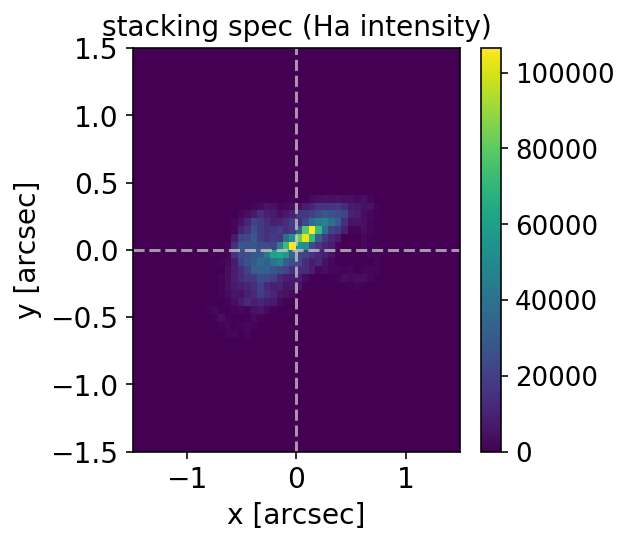

In [19]:
band = 'V'
#imageArr = mock.gen_photometry(band=band, weights='intensity')
#imageArr = mock.gen_photometry(weights='mass')
#image = Image(imageArr, mock.Pars.spaceGrid)

image = Image(mock.specCube)

# add psf
#image.add_psf(psfFWHM=mock.Pars.fid['psfFWHM'], psf_g1=mock.Pars.fid['psf_g1'], psf_g2=mock.Pars.fid['psf_g2'])

# add noise (or not)
#image.array_var = image.gen_image_variance(signal_to_noise=100., add_noise=True)

#title = f'{band} band photometry'
#title = 'star ptl. mass weighted'
title = 'stacking spec (Ha intensity)'
image.display(xlim=[-1.5,1.5], title=title)